## Optimal Portfolio Weights I: Mean-Variance Optimization

In [3]:
# Working with data:
import numpy  as np                                   # For scientific computing.
import pandas as pd                                   # Working with tables.

# Downloading files:
import requests, zipfile, io                          # To access websites.

# Specific data providers:
from tiingo import TiingoClient                       # Stock prices.
import quandl                                         # Economic data, futures prices, ...

# API keys:
tiingo = TiingoClient({'api_key':'f10f5d79cf2567b045cc7e9b595a6fec0f5321d2'})
quandl.ApiConfig.api_key = 'EqpCyveK1jFmUkmzpPjz'

# Plotting:
import matplotlib.pyplot as plt                        # Basic plot library.
plt.style.use('ggplot')                                # Make plots look nice

### Get data

In [6]:
#Get ETF prices and returns (data start in 2003 since Treasury ETFs not available earlier)

PRICE = tiingo.get_dataframe(['SPY','TLT','IEF','SHY'], '2003-1-1', metric_name='adjClose')
#TLT: 20+ year treasuries, IEF: 7-10 year treasuries, SHY: 1-3 year treasuries

PRICE.index = pd.to_datetime(PRICE.index).tz_convert(None)

RET = PRICE.pct_change()
RET[:3]

,SPY,TLT,IEF,SHY
2003-01-02,NaN,NaN,NaN,NaN
2003-01-03,0.003075,0.002318,0.001651,0.000122
2003-01-06,0.017625,-0.002660,-0.002473,-0.000610


Compare stock and treasury compond returns:

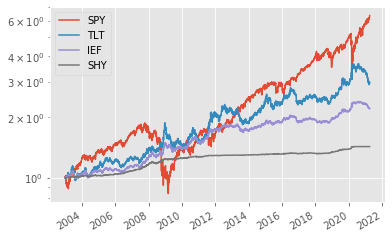

In [7]:
RET.add(1).cumprod().plot(logy=True)

Get federal funds rate and treasury yields:

In [8]:
RATES = quandl.get(['FRED/FEDFUNDS','FRED/DGS1','FRED/DGS5','FRED/DGS10','FRED/DGS30']) / 100
RATES.columns = ['FedFunds','Treasury_1', 'Treasury_5', 'Treasury_10', 'Treasury_30']
RATES

,FedFunds,Treasury_1,Treasury_5,Treasury_10,Treasury_30
Date,,,,,
1954-07-01,0.0080,NaN,NaN,NaN,NaN
1954-08-01,0.0122,NaN,NaN,NaN,NaN
1954-09-01,0.0107,NaN,NaN,NaN,NaN
1954-10-01,0.0085,NaN,NaN,NaN,NaN
1954-11-01,0.0083,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2021-03-29,NaN,0.0006,0.0089,0.0173,0.0243
2021-03-30,NaN,0.0006,0.0090,0.0173,0.0238
2021-03-31,NaN,0.0007,0.0092,0.0174,0.0241


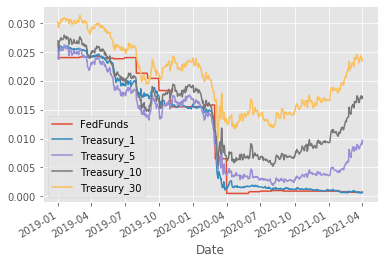

In [12]:
RATES.ffill()['2019':].plot()

Calculate margin rate:

In [9]:
RET = RET.join(RATES.FedFunds.rename('MarginRate'), how='outer')
RET['MarginRate'] = RET.MarginRate.ffill()/252 + 0.01/252           # Assume margin rate = fed funds rate + 100 bsp
RET = RET.dropna(subset=['SPY'])                                    # Drop all rows where we don't have data for SPY
RET

,SPY,TLT,IEF,SHY,MarginRate
2003-01-03,0.003075,0.002318,0.001651,0.000122,0.000089
2003-01-06,0.017625,-0.002660,-0.002473,-0.000610,0.000089
2003-01-07,-0.002474,0.003594,0.003187,0.000732,0.000089
2003-01-08,-0.014451,0.004968,0.002353,0.000853,0.000089
2003-01-09,0.015538,-0.019198,-0.012091,-0.001827,0.000089
...,...,...,...,...,...
2021-03-29,-0.000505,-0.008488,-0.003434,-0.000232,0.000042
2021-03-30,-0.002653,0.005240,-0.000883,0.000000,0.000042
2021-03-31,0.004053,-0.005580,-0.001415,-0.000348,0.000042
2021-04-01,0.010799,0.016575,0.004425,-0.000008,0.000042


### Stocks vs Bonds

Compare annual returns of SPY and TLT:

In [19]:
# Compound daily returns within each year:
#RET[['SPY','TLT']].add(1).resample('A')          .prod().sub(1)  #same thing, but index includes last day of each year 
RET[['SPY','TLT']].add(1).groupby(RET.index.year).prod().sub(1)

,SPY,TLT
2003,0.241793,0.043166
2004,0.107028,0.087111
2005,0.048258,0.086066
2006,0.158482,0.007108
2007,0.051356,0.102911
2008,-0.368069,0.339240
2009,0.263661,-0.218006
2010,0.150577,0.090460
2011,0.018879,0.339593
2012,0.159917,0.026311


Plot this:

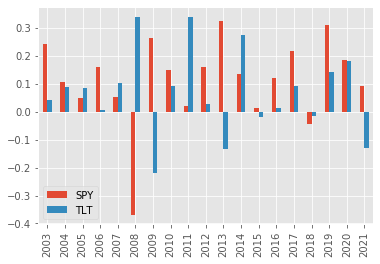

In [21]:
RET[['SPY','TLT']].add(1).groupby(RET.index.year).prod().sub(1).plot.bar()

Compare daily returns in March 2020:

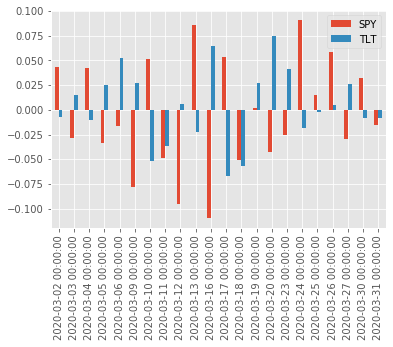

In [22]:
RET.loc['2020-3',['SPY','TLT']].plot.bar()

Daily return February 15 to March 15 2021:

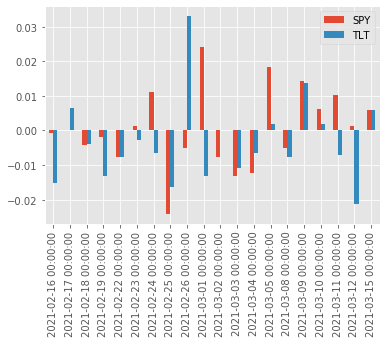

In [27]:
RET.loc['2021-2-15':'2021-3-15',['SPY','TLT']].plot.bar()

Scatter plot of daily returns in 2020:

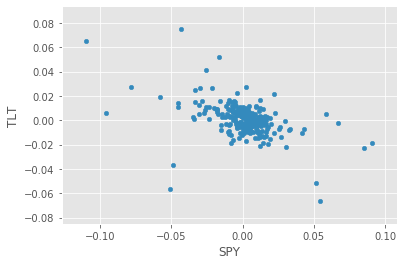

In [24]:
RET.loc['2020'].plot.scatter('SPY','TLT')

Same graph for 2021:

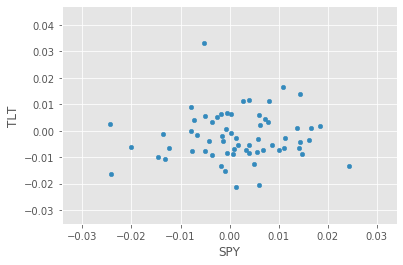

In [25]:
RET.loc['2021'].plot.scatter('SPY','TLT')

Correlation of returns for entire sample:

In [30]:
RET.corr()

,SPY,TLT,IEF,SHY,MarginRate
SPY,1.000000,-0.402390,-0.390339,-0.331498,-0.012482
TLT,-0.402390,1.000000,0.911492,0.571435,0.004984
IEF,-0.390339,0.911492,1.000000,0.744602,0.011905
SHY,-0.331498,0.571435,0.744602,1.000000,0.069698
MarginRate,-0.012482,0.004984,0.011905,0.069698,1.000000


Correlation for each year:

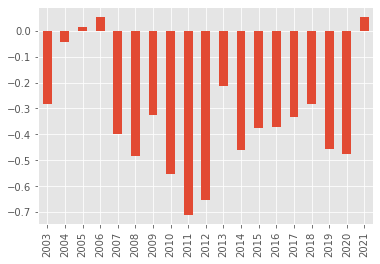

In [33]:
RET[['SPY','TLT']].groupby(RET.index.year).corr().unstack().SPY.TLT.plot.bar()

### Mean-variance optimization

Annual returns:

In [34]:
r_annual = RET[:'2020'].add(1).resample('A').prod().sub(1)
r_annual

,SPY,TLT,IEF,SHY,MarginRate
2003-12-31,0.241793,0.043166,0.037300,0.021914,0.021391
2004-12-31,0.107028,0.087111,0.041268,0.006631,0.023832
2005-12-31,0.048258,0.086066,0.026422,0.015310,0.043118
2006-12-31,0.158482,0.007108,0.025180,0.038910,0.061250
2007-12-31,0.051356,0.102911,0.103745,0.073509,0.061777
2008-12-31,-0.368069,0.339240,0.179071,0.066157,0.029747
2009-12-31,0.263661,-0.218006,-0.065888,0.003526,0.011663
2010-12-31,0.150577,0.090460,0.093724,0.022779,0.011827
2011-12-31,0.018879,0.339593,0.156441,0.014405,0.011074
2012-12-31,0.159917,0.026311,0.036634,0.002762,0.011376


Calculate annual excess returns (subtract 1-year treasury rates):

In [37]:
r_annual_Tbill = RATES.Treasury_1.resample('A').first()   # Yield at the beginning of each year
#r_annual_Tbill = RATES.Treasury_1.groupby(RATES.index.year).first() 
r_annual_Tbill

Date
1954-12-31       NaN
1955-12-31       NaN
1956-12-31       NaN
1957-12-31       NaN
1958-12-31       NaN
               ...  
2017-12-31    0.0089
2018-12-31    0.0183
2019-12-31    0.0260
2020-12-31    0.0156
2021-12-31    0.0010
Freq: A-DEC, Name: Treasury_1, Length: 68, dtype: float64

In [38]:
rx_annual = r_annual.sub(r_annual_Tbill, 'rows').dropna() # Subtract a series from a table with table.sub(series, 'rows')
rx_annual

,SPY,TLT,IEF,SHY,MarginRate
2003-12-31,0.227593,0.028966,0.023100,0.007714,0.007191
2004-12-31,0.093928,0.074011,0.028168,-0.006469,0.010732
2005-12-31,0.020358,0.058166,-0.001478,-0.012590,0.015218
2006-12-31,0.114682,-0.036692,-0.018620,-0.004890,0.017450
2007-12-31,0.001356,0.052911,0.053745,0.023509,0.011777
2008-12-31,-0.399769,0.307540,0.147371,0.034457,-0.001953
2009-12-31,0.259661,-0.222006,-0.069888,-0.000474,0.007663
2010-12-31,0.146077,0.085960,0.089224,0.018279,0.007327
2011-12-31,0.015979,0.336693,0.153541,0.011505,0.008174
2012-12-31,0.158717,0.025111,0.035434,0.001562,0.010176


Risk premiums:

In [41]:
meanx = rx_annual[['SPY','TLT']].mean()
meanx

SPY    0.100888
TLT    0.064561
dtype: float64

Example weights:

In [42]:
w = pd.Series({'SPY':0.7, 'TLT':0.3})
w

SPY    0.7
TLT    0.3
dtype: float64

Calculate portfolio risk premium:

$$
\text{portfolio risk premium}
\hspace{1em}=\hspace{1em}
\mathbf{w}\cdot E[\mathbf{r}^x]
\hspace{1em}=\hspace{1em}
\underbrace{\begin{bmatrix}0.7&0.3\end{bmatrix} \times \begin{bmatrix}0.100888\\0.064561\end{bmatrix}}_\text{"dot product"}
\hspace{1em}=\hspace{1em}
\underbrace{0.7 \times 0.100888 + 0.3 \times 0.064561}_\text{weighted average}
$$

Implement this calculation:

In [47]:
w.multiply(meanx).sum()


0.08999016538623958

In [48]:
w.dot(meanx) #to use dot product 

0.08999016538623958

The portfolio variance is the dot product between the portfolio weights and the covariance matrix:

$$
\text{portfolio variance } =  \text{weights }\times\text{ covariance matrix }\times\text{ weights}
$$

Implement this:

In [51]:
# Covariance matrix:
cov = RET[['SPY','TLT']].cov() * 252
cov

,SPY,TLT
SPY,0.036210,-0.010649
TLT,-0.010649,0.019343


Portfolio volatility:

In [53]:
w.dot(cov).dot(w) ** 0.5

0.12252024425183612

Repeat this calculation for multiple weights:

In [55]:
t = pd.DataFrame(index=range(11))

for i in t.index:
    w                       = pd.Series({'SPY':i/10, 'TLT':1-i/10})
    t.loc[i,'SPY']          = w.SPY
    t.loc[i,'TLT']          = w.TLT
    t.loc[i,'Risk_premium'] = w.dot(meanx)
    t.loc[i,'Volatility']   = w.dot(cov).dot(w) ** 0.5

t['Sharpe'] =    t.Risk_premium / t.Volatility
t

,SPY,TLT,Risk_premium,Volatility,Sharpe
0,0.0,1.0,0.064561,0.139079,0.464207
1,0.1,0.9,0.068194,0.118798,0.574033
2,0.2,0.8,0.071827,0.102079,0.703640
3,0.3,0.7,0.075459,0.090908,0.830066
4,0.4,0.6,0.079092,0.087438,0.904551
5,0.5,0.5,0.082725,0.092540,0.893937
6,0.6,0.4,0.086357,0.104971,0.822680
7,0.7,0.3,0.089990,0.122520,0.734492
8,0.8,0.2,0.093623,0.143320,0.653244
9,0.9,0.1,0.097256,0.166153,0.585336


Plot risk vs return:

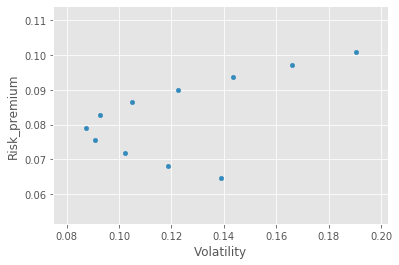

In [56]:
t.plot.scatter('Volatility','Risk_premium')

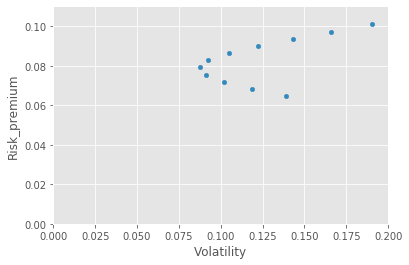

In [57]:
t.plot.scatter('Volatility','Risk_premium', xlim=(0,0.2), ylim=(0,0.11))

Maximum Sharpe ratio weights:

$$
\mathbf{w} = \frac{\mathbf{\Sigma}^{-1}E[\mathbf{r}^x]}{\text{Sum}\big(\mathbf{\Sigma}^{-1}E[\mathbf{r}^x]\big)}
$$

($\Sigma=$ covariance matrix).    

Calculate the inverse of the covariance matrix:

In [58]:
np.linalg.inv(cov)

array([[32.95187294, 18.14189977],
       [18.14189977, 61.68663144]])

Make this easier to read:

In [59]:
cov_inv = pd.DataFrame(np.linalg.inv(cov), columns=cov.columns, index=cov.index)
cov_inv

,SPY,TLT
SPY,32.951873,18.141900
TLT,18.141900,61.686631


Maximum Sharpe ratio weights:

In [60]:
w_maxSharpe = cov_inv.dot(meanx) / cov_inv.dot(meanx).sum()
w_maxSharpe

SPY    0.436114
TLT    0.563886
dtype: float64

Minimum volatility portfolio weights:

$$
\mathbf{w_{minvol}}
= \frac{\mathbf{\Sigma}^{-1}\mathbf{1}}{\text{Sum}\big(\mathbf{\Sigma}^{-1}\mathbf{1}\big)}
$$

where $\mathbf{1}$ is a vector of ones and $\mathbf{\Sigma}^{-1}\mathbf{1}$ is row or column sum of the inverse covariance matrix.

Implement this:

In [62]:
w_minVol = cov_inv.sum() / cov_inv.sum().sum()
w_minVol

SPY    0.39026
TLT    0.60974
dtype: float64

Compound returns of optimal portfolios

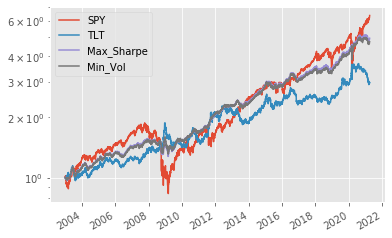

In [67]:
t = pd.DataFrame()
t['SPY']        = RET.SPY
t['TLT']        = RET.TLT
t['Max_Sharpe'] = RET.multiply(w_maxSharpe).sum('columns')
t['Min_Vol']    = RET.multiply(w_minVol).sum('columns')

t.add(1).cumprod().plot(logy=True)

### Optimal portfolios with leverage

In [ ]:
w_maxSharpe

Add cash to these weights:

In [ ]:
w_maxSharpe.append(pd.Series({'MarginRate':0}))  # No leverage

In [ ]:
w_maxSharpe_levered = 
w_maxSharpe_levered

Check that weights sum to one:

Compare compound returns:

In [ ]:
t = pd.DataFrame()
t['SPY']        = RET.SPY
t['TLT']        = RET.TLT
t['Max_Sharpe'] = 
t['MS_levered'] = 
t.add(1).cumprod().plot(logy=True)

Compare Sharpe ratios:

In [ ]:
annual_returns = t[:'2020'].add(1).resample('A').prod().sub(1)

x = pd.DataFrame()                        
x['Average_returns'] = annual_returns.mean()
x['Risk_premium']    = annual_returns.sub(r_annual_Tbill, 'rows').dropna().mean()
x['Volatility']      = t[:'2020'].std() * 252**0.5    
x['Sharpe_ratio']    = x.Risk_premium / x.Volatility
x

Compare drawdowns:

In [ ]:
hwm = t.add(1).cumprod().cummax()         # high water mark

drawdown = t.add(1).cumprod()/hwm - 1.0   # % portfolio loss relative to most recent peak (high water mark)
drawdown.plot()

How did this strategy perform since 2020?